In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
import tensorflow_dataset as tfds
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import pathlib

In [2]:
dataset_dir =  "./final_project_dataset"
# Đường dẫn file training
data_train = pathlib.Path(dataset_dir + "/training_set")
# Đường dẫn file test
data_test = pathlib.Path(dataset_dir + "/test_set") 
#Số lượng ảnh có trong file training và test
train_count = len(list(data_train.glob('*/*.jpg')))
test_count = len(list(data_test.glob('*/*.jpg')))
train_count, test_count

(14034, 3000)

In [3]:
batch_size = 64
img_height = 150
img_width = 150

epochs = 20

In [4]:

train_datagen = ImageDataGenerator(
        rotation_range=3,
        zoom_range=0.05,
        width_shift_range=0.02,
        height_shift_range=0.02,
        #horizontal_flip=True,
        fill_mode="nearest")

test_datagen = ImageDataGenerator()

In [5]:
train_ds = train_datagen.flow_from_directory(
    data_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123,
    class_mode='categorical')

val_ds = test_datagen.flow_from_directory(
    data_test,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123,
    class_mode='categorical')

#class_names = train_ds.class_names
#(class_names)
#print(train_ds)


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

AttributeError: 'DirectoryIterator' object has no attribute 'take'

<Figure size 1000x1000 with 0 Axes>

In [ ]:
#AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:

lr_reducer = ReduceLROnPlateau(factor = np.sqrt(0.1),
                               cooldown = 0,
                               patience = 2,
                               min_lr = 0.5e-6)

In [22]:
#num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="same"),
  layers.Conv2D(32, 3, padding='same', activation= 'relu'),
  layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="same"),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation= 'relu'),
  layers.Conv2D(64, 3, padding='same', activation= 'relu'),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(128, 3, padding='same', activation= 'relu'),
  layers.Conv2D(128, 3, padding='same', activation= 'relu'),
  layers.BatchNormalization(),
  layers.GlobalAveragePooling2D(),
  layers.Flatten(),
  layers.Dropout(0.4),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(6, activation='softmax')
])

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 38, 38, 32)       0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 38, 38, 32)       

In [25]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [lr_reducer]
)

Epoch 1/20
220/220 [==============================] - 146s 656ms/step - loss: 1.1045 - accuracy: 0.5631 - val_loss: 1.1043 - val_accuracy: 0.5967 - lr: 0.0010
Epoch 2/20
220/220 [==============================] - 148s 673ms/step - loss: 0.7462 - accuracy: 0.7217 - val_loss: 0.6543 - val_accuracy: 0.7483 - lr: 0.0010
Epoch 3/20
220/220 [==============================] - 148s 671ms/step - loss: 0.6529 - accuracy: 0.7603 - val_loss: 1.1875 - val_accuracy: 0.5993 - lr: 0.0010
Epoch 4/20
220/220 [==============================] - 148s 672ms/step - loss: 0.6203 - accuracy: 0.7708 - val_loss: 1.2244 - val_accuracy: 0.5770 - lr: 0.0010
Epoch 5/20
220/220 [==============================] - 148s 672ms/step - loss: 0.5145 - accuracy: 0.8154 - val_loss: 0.5601 - val_accuracy: 0.7973 - lr: 3.1623e-04
Epoch 6/20
220/220 [==============================] - 148s 673ms/step - loss: 0.4883 - accuracy: 0.8224 - val_loss: 0.6310 - val_accuracy: 0.7847 - lr: 3.1623e-04
Epoch 7/20
220/220 [==================

KeyboardInterrupt: 

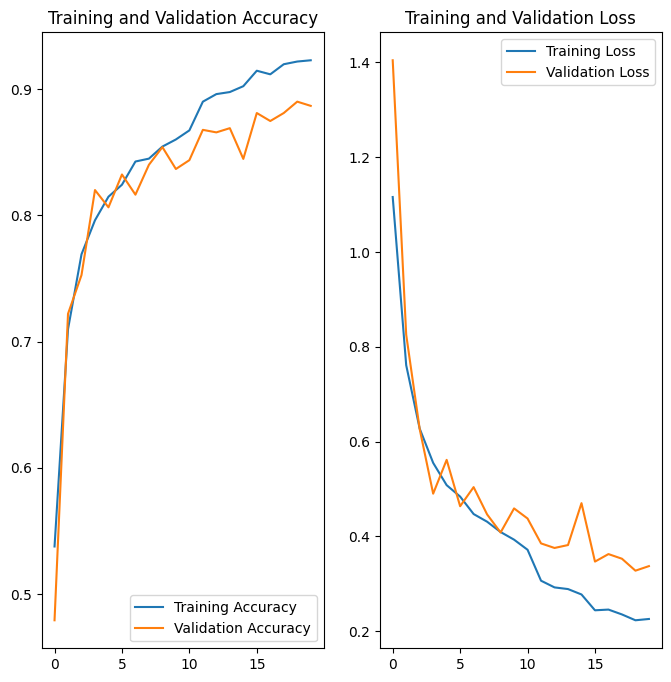

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
